In [25]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
# GPU 환경확인
tf.config.list_physical_devices('GPU')

In [7]:
# dataset download
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


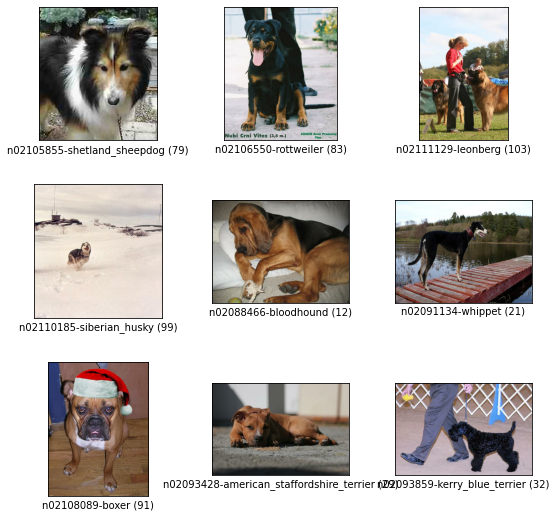

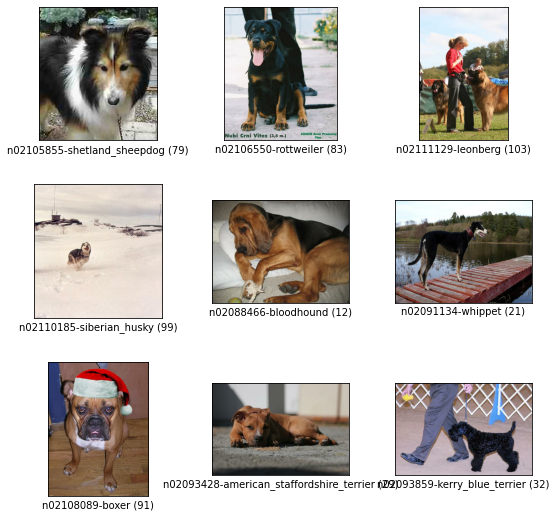

In [8]:
tfds.show_examples(ds_train, ds_info)

In [18]:
# CutMix
# 바탕 이미지에 삽입될 영역의 바운딩 박스 구하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

# 두 이미지를 합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# 라벨을 섞는 함수
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# 배치 단위로 CutMix
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# Mixup
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

# 배치 단위로 Mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [20]:
# 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# make random augment function
def augment2(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

In [13]:
num_classes = ds_info.features["label"].num_classes

In [15]:
# 기본 모델 불러오기 : keras ResNet50, trained by ImageNet
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
# aug. 학습용 모델 불러오기
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
# 4 different datasets
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [22]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

# 기본 학습
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 198s 203ms/step - loss: 2.2103 - accuracy: 0.4471 - val_loss: 3.2937 - val_accuracy: 0.2181
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.7454 - accuracy: 0.7954 - val_loss: 1.2713 - val_accuracy: 0.6416
Epoch 3/20
750/750 [==============================] - 153s 203ms/step - loss: 0.2240 - accuracy: 0.9551 - val_loss: 0.9906 - val_accuracy: 0.7105
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0674 - accuracy: 0.9934 - val_loss: 0.9349 - val_accuracy: 0.7346
Epoch 5/20
750/750 [==============================] - 153s 203ms/step - loss: 0.0264 - accuracy: 0.9994 - val_loss: 0.9343 - val_accuracy: 0.7359
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0176 - accuracy: 0.9996 - val_loss: 0.9513 - val_accuracy: 0.7366
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0148 - accuracy: 0.9998 - val_loss: 0.9626 -

In [26]:
EPOCH = 20

# aug. 학습
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 154s 196ms/step - loss: 2.2996 - accuracy: 0.4273 - val_loss: 3.0836 - val_accuracy: 0.2638
Epoch 2/20
750/750 [==============================] - 150s 200ms/step - loss: 0.9380 - accuracy: 0.7314 - val_loss: 1.2632 - val_accuracy: 0.6334
Epoch 3/20
750/750 [==============================] - 152s 203ms/step - loss: 0.4878 - accuracy: 0.8687 - val_loss: 1.1425 - val_accuracy: 0.6693
Epoch 4/20
750/750 [==============================] - 152s 203ms/step - loss: 0.2459 - accuracy: 0.9418 - val_loss: 0.9951 - val_accuracy: 0.7111
Epoch 5/20
750/750 [==============================] - 152s 203ms/step - loss: 0.1405 - accuracy: 0.9728 - val_loss: 1.0697 - val_accuracy: 0.7025
Epoch 6/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0745 - accuracy: 0.9908 - val_loss: 1.0274 - val_accuracy: 0.7194
Epoch 7/20
750/750 [==============================] - 152s 203ms/step - loss: 0.0483 - accuracy: 0.9948 - val_loss: 0.9617 -

In [28]:
# cutmix 학습용 모델 불러오기
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# cutmix 학습
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 207ms/step - loss: 3.8608 - accuracy: 0.2071 - val_loss: 3.4160 - val_accuracy: 0.2113
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 3.0051 - accuracy: 0.4123 - val_loss: 1.3867 - val_accuracy: 0.6026
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.7342 - accuracy: 0.4938 - val_loss: 1.2225 - val_accuracy: 0.6554
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 2.5530 - accuracy: 0.5497 - val_loss: 1.2170 - val_accuracy: 0.6656
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 2.4633 - accuracy: 0.5827 - val_loss: 1.3904 - val_accuracy: 0.6253
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 2.3144 - accuracy: 0.6297 - val_loss: 1.1132 - val_accuracy: 0.6905
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2152 - accuracy: 0.6579 - val_loss: 1.0735 -

In [31]:
# mixup 학습용 모델 불러오기
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# mixup 학습
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 162s 206ms/step - loss: 3.7867 - accuracy: 0.2187 - val_loss: 3.5775 - val_accuracy: 0.1860
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 2.9610 - accuracy: 0.4462 - val_loss: 1.6421 - val_accuracy: 0.5479
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6795 - accuracy: 0.5432 - val_loss: 1.5598 - val_accuracy: 0.5701
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 2.5427 - accuracy: 0.5907 - val_loss: 1.4833 - val_accuracy: 0.5927
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.4019 - accuracy: 0.6499 - val_loss: 1.3585 - val_accuracy: 0.6265
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.3019 - accuracy: 0.6787 - val_loss: 1.3347 - val_accuracy: 0.6375
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 2.2385 - accuracy: 0.7086 - val_loss: 1.3281 -

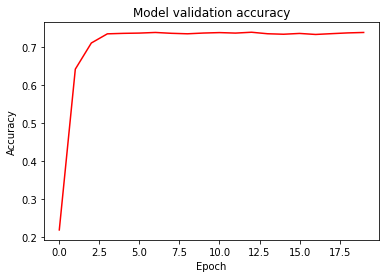

In [23]:
# 기본 acc 플랏
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.show()

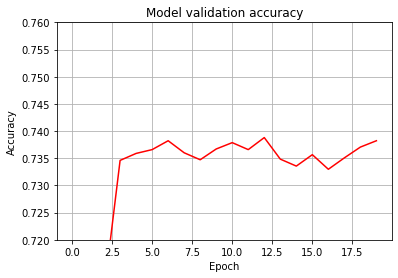

In [24]:
# 확대된 acc 플랏
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

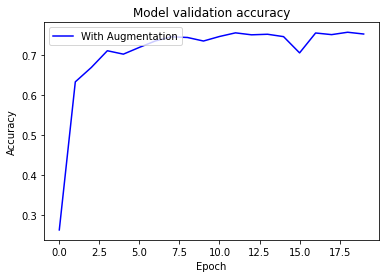

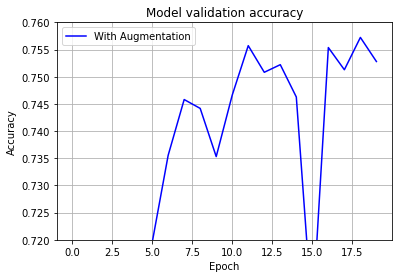

In [27]:
# augment 기본, 확대 plot
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With Augmentation'], loc='upper left')
plt.show()

plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

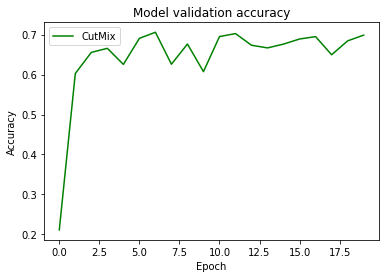

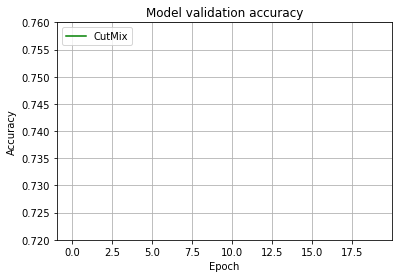

In [29]:
# cutmix 기본, 확대 plot
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix'], loc='upper left')
plt.show()

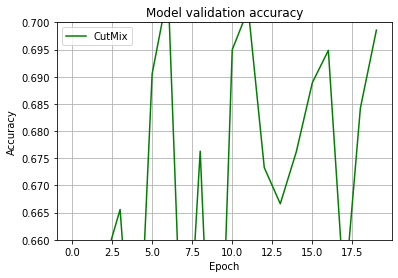

In [30]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['CutMix'], loc='upper left')
plt.grid(True)
plt.ylim(0.66, 0.70)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

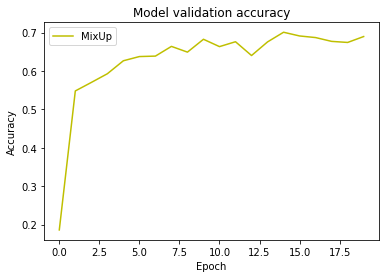

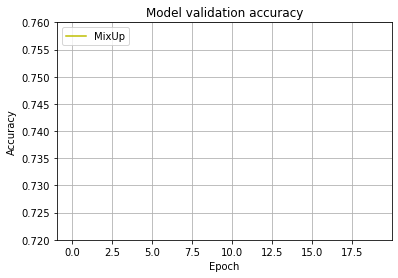

In [32]:
# mixup 기본, 확대 plot
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MixUp'], loc='upper left')
plt.show()

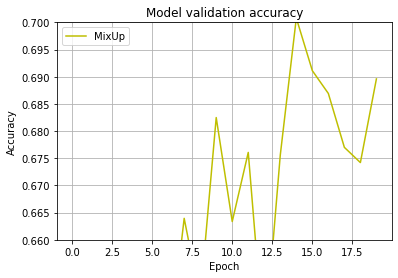

In [33]:
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.66, 0.70)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

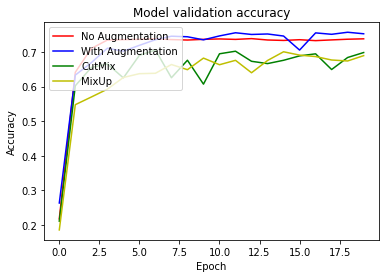

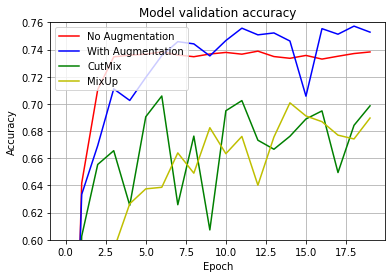

In [36]:
# 한번에 뽑기 (가능?)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.show()

# 확대
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

# 결과 분석
1. Aug. 만 한 데이터셋의 정확도가 가장 좋았다
2. CutMix와 MixUp은 비슷하게 정확도가 조금 떨어졌다.
- 이유는?
Augmentation의 효과를 내려면 원래 데이터셋을 그대로 보존하고 CutMix, MixUp으로 만든 데이터셋을 합쳐야 한다.
데이터 개수는 그대로 두고 라벨을 섞은 샘플의 비율만 늘려서 오히려 학습에 혼동을 주었을 것이다.